In [27]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.datasets import load_files
import numpy as np
import cv2
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

In [3]:

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
val_x, val_y,_ = load_dataset(val_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Loading complete!
Training set size :  5216
Testing set size :  624


In [4]:
numberOfClasses = len(np.unique(y_train)) # class labels
numberOfClasses

2

In [5]:
val_y[0:5]


array([0, 0, 1, 1, 1])

In [6]:

y_train = np_utils.to_categorical(y_train,numberOfClasses)
y_test = np_utils.to_categorical(y_test,numberOfClasses)

val_y = np_utils.to_categorical(val_y,numberOfClasses)


val_y[0:5]# Note that only one element has value 1(corresponding to its label) and others are 0.

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
print('Vaildation X : ',val_x.shape)
print('Vaildation y :',val_y.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)

Vaildation X :  (16,)
Vaildation y : (16, 2)
Test X :  (624,)
Test y :  (624, 2)


In [8]:
x_train[0]

'../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1493_bacteria_3896.jpeg'

In [9]:


def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append((img_to_array(load_img(file, target_size=(256,256))))/255) # change the target size is a neccesary. Becasue ram is not enough for orijinal size image
    return images_as_array


In [10]:
x_train = np.array(convert_image_to_array(x_train))
print('Validation set shape : ',x_train.shape)


Validation set shape :  (5216, 256, 256, 3)


In [11]:
val_x = np.array(convert_image_to_array(val_x))
print('Validation set shape : ',val_x.shape)



Validation set shape :  (16, 256, 256, 3)


In [12]:


x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (624, 256, 256, 3)


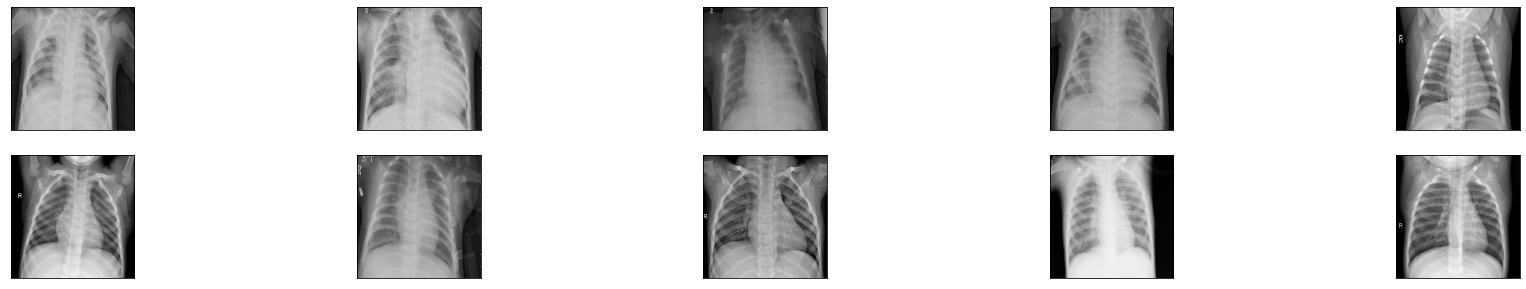

In [13]:


fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [14]:
dataGen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.1,
                             rotation_range = 10
                                      )

In [15]:
dataGen.fit(x_train)


In [16]:
x_train.shape
val_x.shape

(16, 256, 256, 3)

In [17]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(units=1028,activation="relu"))
    model.add(Dense(units=1028,activation="relu"))
    model.add(Dense(units=2, activation="sigmoid"))

    return model


In [18]:
model=VGG16()

2022-11-11 12:23:04.120444: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
from tensorflow.keras.optimizers import Adam
import keras
opt = Adam(learning_rate= 0.000001)
model.compile(optimizer=opt, loss="BinaryCrossentropy", metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0

In [21]:
#es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [22]:
batch_size = 32

hist = model.fit(dataGen.flow(x_train, y_train, batch_size = batch_size), 
                                        validation_data = (x_test, y_test),
                                        epochs = 5,steps_per_epoch = 10, shuffle = 1) #callbacks = [es])

2022-11-11 12:23:05.816827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
10/10 [==============================] - 676s 69s/step - loss: 0.6927 - accuracy: 0.5594 - val_loss: 0.6929 - val_accuracy: 0.6250
Epoch 2/5
10/10 [==============================] - 663s 69s/step - loss: 0.6902 - accuracy: 0.7219 - val_loss: 0.6926 - val_accuracy: 0.6250
Epoch 3/5
10/10 [==============================] - 681s 70s/step - loss: 0.6839 - accuracy: 0.7344 - val_loss: 0.6917 - val_accuracy: 0.6250
Epoch 5/5
10/10 [==============================] - 698s 72s/step - loss: 0.6800 - accuracy: 0.7188 - val_loss: 0.6909 - val_accuracy: 0.6250


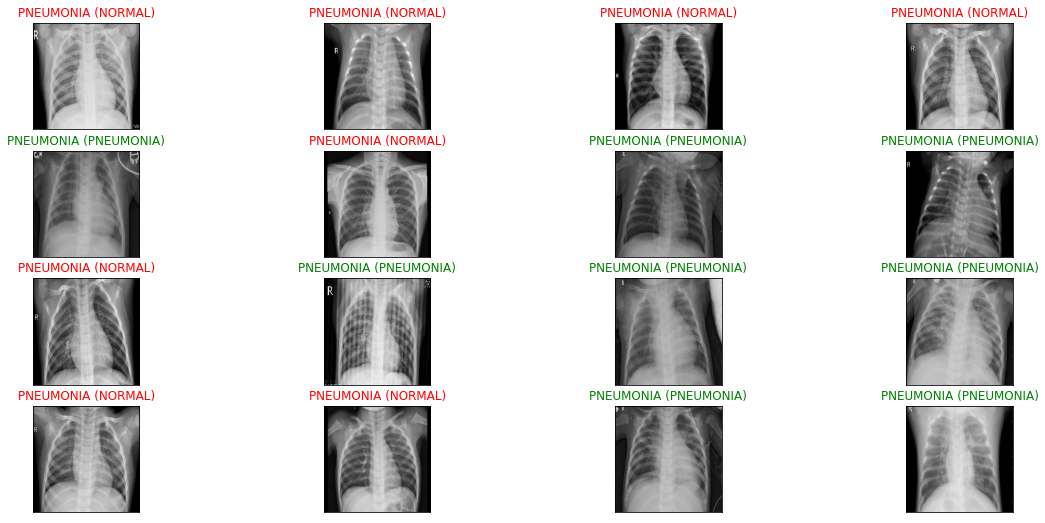

In [33]:
y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

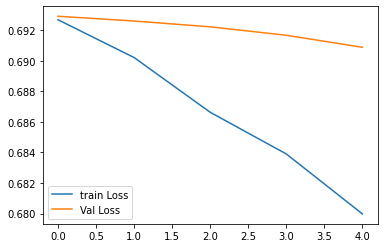

In [30]:
hist.history.keys()

plt.figure()
plt.plot(hist.history["loss"], label = "train Loss")
plt.plot(hist.history["val_loss"], label = "Val Loss")
plt.legend()
plt.show()

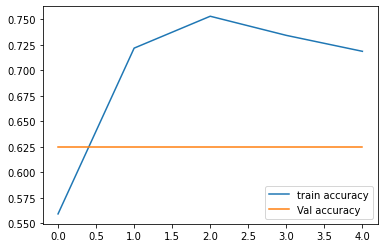

In [31]:
plt.figure()
plt.plot(hist.history["accuracy"], label = "train accuracy")
plt.plot(hist.history["val_accuracy"], label = "Val accuracy")
plt.legend()
plt.show()

### we have a problem on "normal" image. Im workin on it...